# Online Retail
### 목표 : 전자상 거래 데이터를 활용해 고객 리텐션을 분석하고, 재방문율을 높이는 방안 제시

In [21]:
!wget --no-check-certificate "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx" -O OnlineRetail.xlsx

--2025-11-26 05:02:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘OnlineRetail.xlsx’

OnlineRetail.xlsx       [     <=>            ]  22.62M  25.2MB/s    in 0.9s    

2025-11-26 05:02:57 (25.2 MB/s) - ‘OnlineRetail.xlsx’ saved [23715344]



In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [23]:

df = pd.read_excel("OnlineRetail.xlsx")
ecommerce = df.copy()

## Data Column

###### InvoiceNo : 주문번호
###### StockCode : 제품 코드
###### Description : 제품 설명
###### Quantity : 수량
###### InvoiceDate : 주문일시
###### UnitPrice : 단가
###### CustomerID : 고객 ID
###### Country : 국가

## Data Describe

In [24]:
ecommerce

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [25]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [26]:
ecommerce.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


#### 해당 플랫폼의 주요 고객은 영국 국적을 가지고 있음을 알 수 있음

<Axes: xlabel='Country', ylabel='count'>

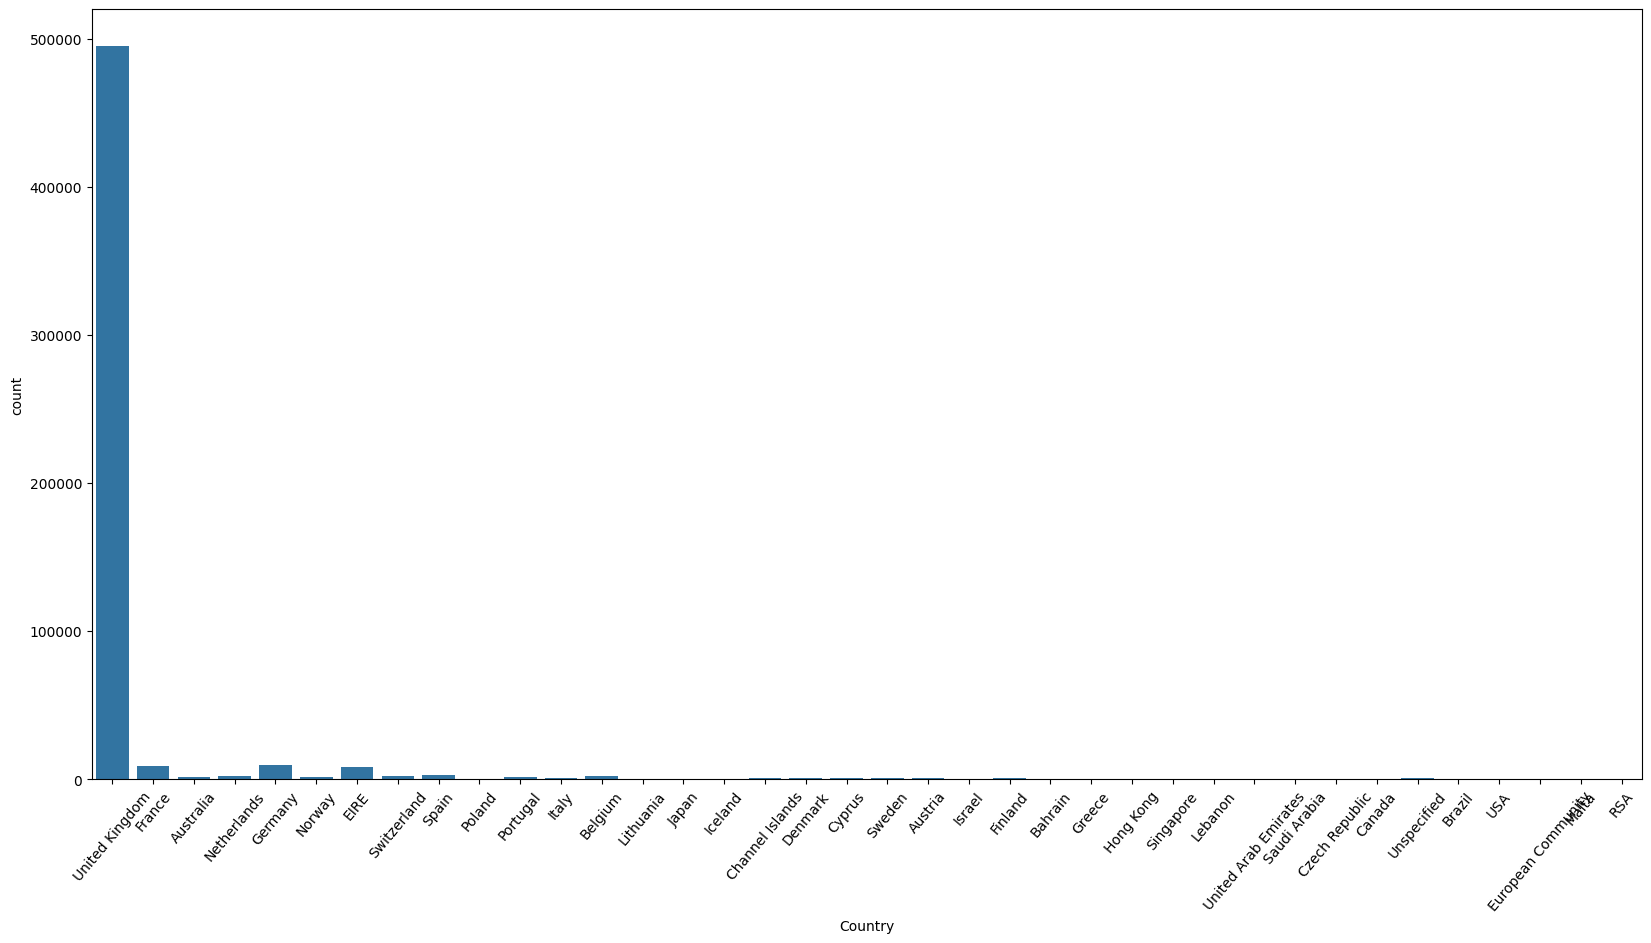

In [27]:
plt.figure(figsize = (20, 10))
plt.xticks(rotation = 50)

sns.countplot(data = ecommerce, x= 'Country')

## Data Processing

##### CustomerID가 없는 경우 => Drop(비회원 일수도 있음)
##### Quantity가 음수인 경우 => Drop(반품)
##### UnitPrice가 음수인 경우 => Drop
##### Cohort 분석 대상 국가 : 영국으로 진행

In [28]:
ecommerce = ecommerce.dropna(subset=['CustomerID'])
ecommerce = ecommerce[ecommerce['Quantity'] > 0]
ecommerce = ecommerce[ecommerce['UnitPrice'] > 0]
ecommerce = ecommerce[ecommerce['Country'] == 'United Kingdom']

## Feature Engineering

- ##### 수량 * 단가 => 구매 가격 Feature 추가
- ##### **월** 관련 Feature 추가
- ##### 고객ID별 처음 상품을 구매한 년, 월 Feature 추가 (Retention)
- ##### 고객ID별 거래 기록과 첫 상품구매월간 단위 차이 Feature 추가 (Retention)

In [29]:
ecommerce['Price'] = ecommerce['UnitPrice'] * ecommerce['Quantity']
ecommerce['Month'] = ecommerce['InvoiceDate'].dt.to_period('M')

# CustomerID별 첫 구매 년, 월 계산
ecommerce['BuyFirstMonth'] = ecommerce.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 각 거래의 구매월과 첫 구매월 간의 월 단위 차이를 계산
ecommerce['MonthDiff'] = (ecommerce['InvoiceDate'].dt.year - ecommerce['BuyFirstMonth'].dt.year) * 12 + (ecommerce['InvoiceDate'].dt.month - ecommerce['BuyFirstMonth'].dt.month)

##### 상품의 개수가 약 4000개 가량 존재 -> TF-IDF를 통해 리그룹
##### 3844 >> 164

In [30]:
# TF-IDF 모델 생성
N = 255  # 상위 N개의 키워드 추출
vectorizer = TfidfVectorizer(stop_words='english')
TFIDF_matrix = vectorizer.fit_transform(ecommerce['Description'])

# 각 단어에 대한 TF-IDF 값 추출
TFIDF_scores = TFIDF_matrix.sum(axis=0)

# TF-IDF 값이 높은 단어 순으로 정렬
TFIDF_df = pd.DataFrame(TFIDF_scores, columns=vectorizer.get_feature_names_out()).transpose()
TFIDF_df.columns = ['tfidf_score']
TFIDF_df = TFIDF_df.sort_values(by='tfidf_score', ascending=False)

# 상위 N개의 키워드 추출
top_keywords = TFIDF_df.head(N).index.tolist()

# 'category' 열 생성 및 할당
ecommerce['category'] = ecommerce['Description'].apply(lambda x: next((keyword for keyword in top_keywords if keyword in x.lower()), None))

# customer_id가 null이 아닌 행들 추출
ecommerce = ecommerce[pd.notnull(ecommerce['CustomerID'])]


## Rentention Analysis
Cohort 그룹 : 고객의 첫 구매일

In [31]:
# Retention Rate

def get_Retention(df: pd.DataFrame) -> pd.DataFrame:

    cohort = df.groupby(['BuyFirstMonth', 'MonthDiff'])['CustomerID'].nunique().reset_index()

    cohort_sizes = cohort[cohort['MonthDiff'] == 0][['BuyFirstMonth', 'CustomerID']]
    cohort_sizes = cohort_sizes.rename(columns={'CustomerID': 'TotalCount'})

    cohort = cohort.merge(cohort_sizes, on='BuyFirstMonth')

    cohort['RetentionRate'] = cohort['CustomerID'] / cohort['TotalCount']

    return cohort

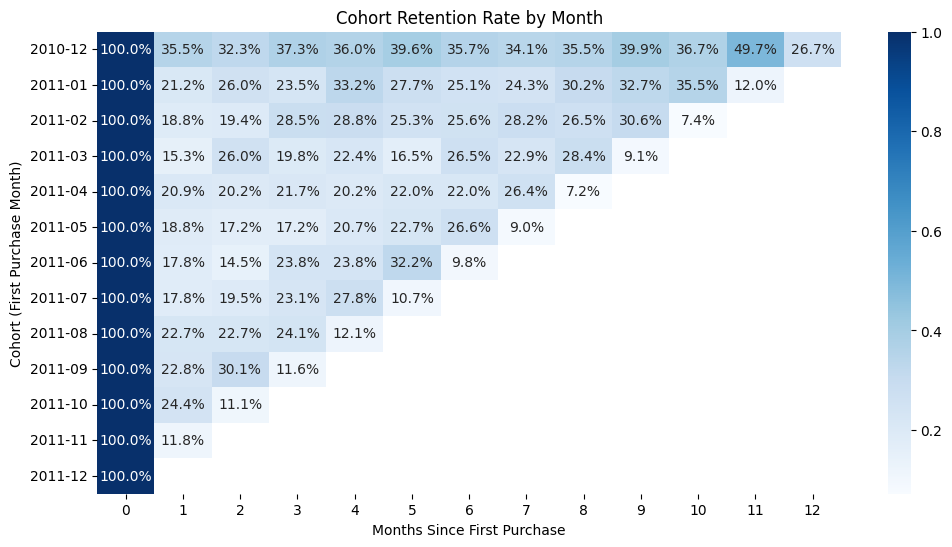

In [32]:
# Retention 계산
cohort_data = get_Retention(ecommerce)

# 시각화를 위한 Pivot Table 생성
retention_table = cohort_data.pivot(index='BuyFirstMonth', columns='MonthDiff', values='RetentionRate')
retention_table.round(3)

plt.figure(figsize=(12, 6))
sns.heatmap(retention_table, annot=True, fmt=".1%", cmap="Blues")
plt.title("Cohort Retention Rate by Month")
plt.ylabel("Cohort (First Purchase Month)")
plt.xlabel("Months Since First Purchase")
plt.show()

### Notes

#### 1. 2010년 12월 첫 구매후 11개월이 지난 시점에서의 재구매율이 50%에 준함

##### 2010년 12월 구매 물품 및 2011년 11월 재구매 물품

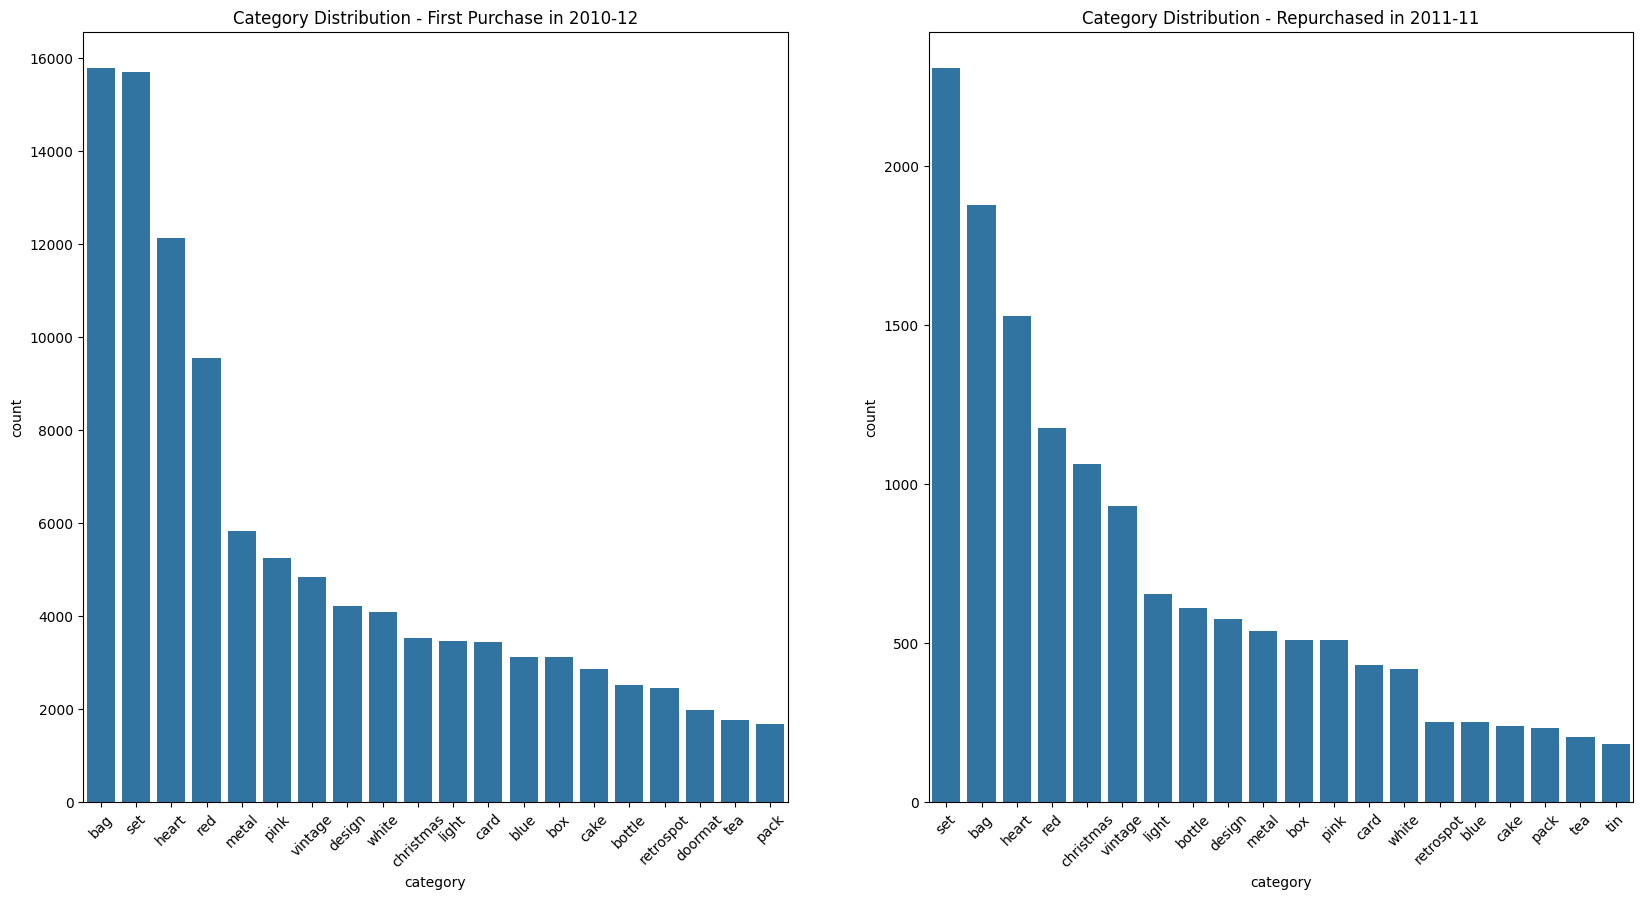

In [33]:
# 날짜 필터링
target_2010 = pd.Period('2010-12', freq='M')
target_2011 = pd.Period('2011-11', freq='M')

# 2010년 12월 카테고리 집계 (상위 20개)
category_2010 = ecommerce[ecommerce['BuyFirstMonth'] == target_2010]['category'].value_counts().reset_index().head(20)
category_2010.columns = ['category', 'count']

# 2010년 12월 구매자 ID
customer_2010 = ecommerce[ecommerce['BuyFirstMonth'] == target_2010]['CustomerID'].unique()

# 2010년 12월 구매자가 2011년 11월에도 구매한 카테고리
category_2011 = ecommerce[(ecommerce['Month'] == target_2011) & (ecommerce['CustomerID'].isin(customer_2010))]['category'].value_counts().reset_index().head(20)
category_2011.columns = ['category', 'count']

# 시각화
figure, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(data=category_2010, x='category', y='count', ax = axes[0])
axes[0].set_title('Category Distribution - First Purchase in 2010-12')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=category_2011, x='category', y='count', ax = axes[1])
axes[1].set_title('Category Distribution - Repurchased in 2011-11')
axes[1].tick_params(axis='x', rotation=45)

plt.show()



##### 크리스마스 관련 상품 구매보다는 일반적인 상품의 구매 비중이 높음
##### Q. 2010년 12월 Cohort 그룹이 구매한 주요 상품은 무엇일까?


##### 첫 구매가 2010년 12월인 코호트 그룹의 구매 물품

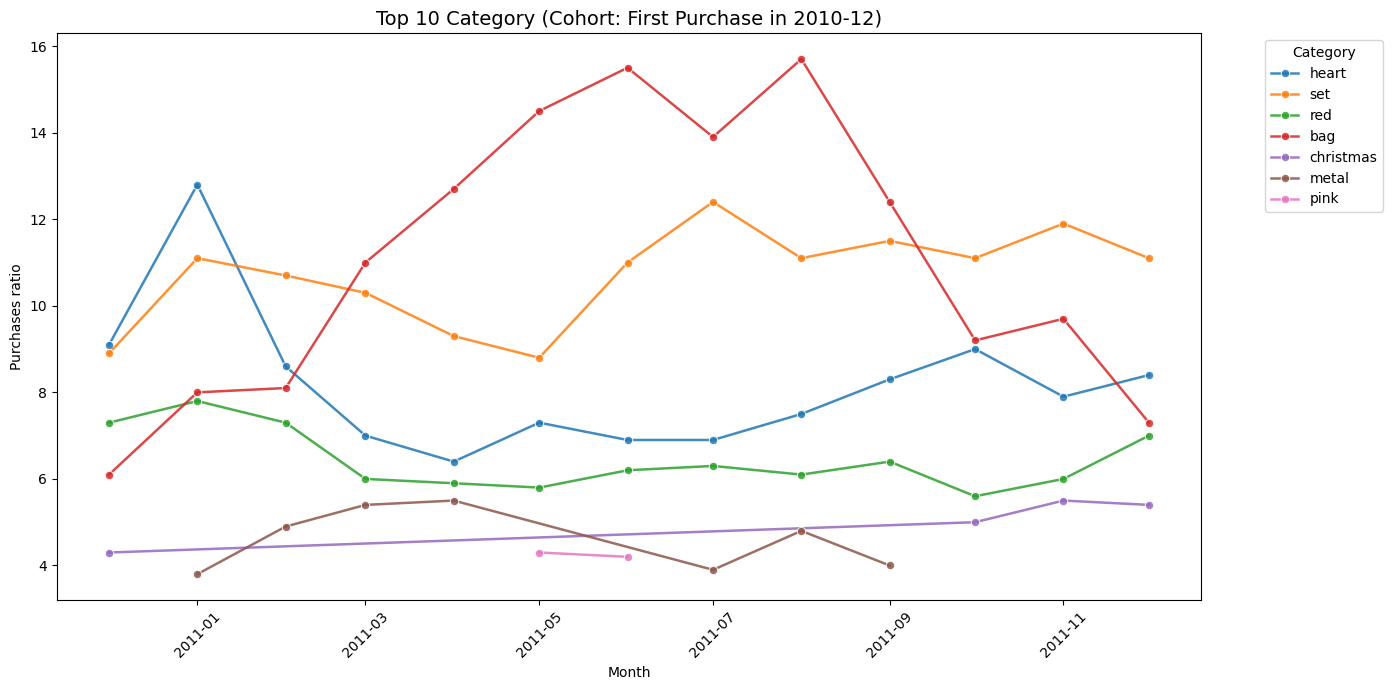

In [34]:
# 2010년 12월 첫 구매 고객(cohort_2010)의 이후 월별 구매 데이터를 추출
cohort_data = (ecommerce[ecommerce['CustomerID'].isin(customer_2010)].groupby(['Month', 'category']).size().reset_index(name='count'))

cohort_data['Month'] = cohort_data['Month'].dt.to_timestamp()

# 각 월별 총 구매 건수(total) 계산 및 카테고리별 비율
cohort_data['total'] = cohort_data.groupby('Month')['count'].transform('sum')
cohort_data['category_ratio'] = (cohort_data['count'] / cohort_data['total'] * 100).round(1)

# 각 월별 카테고리 구매 비율 상위 5개
cohort_data = cohort_data.sort_values(['Month', 'category_ratio'], ascending=[True, False]).groupby('Month').head(5)

# 시각화
plt.figure(figsize = (14, 7))

sns.lineplot(data = cohort_data, x = 'Month', y = 'category_ratio', hue = 'category', marker = 'o', linewidth = 1.8, alpha = 0.85)

plt.title('Top 10 Category (Cohort: First Purchase in 2010-12)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Purchases ratio')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


> #####  비시즌성 아이템(bag, set)의 경우 수요가 지속되며 </br>시즌성 아이템(heart, red, christmas)의 재구매율은 상대적으로 낮은 경향을 보임


#### 2. 2011년 1 ~ 6월까지의 신규 고객들의 첫 구매 비율이 낮아짐

##### 2010년 12월 ~ 2011년 6월 Cohort 그룹 구매 상품

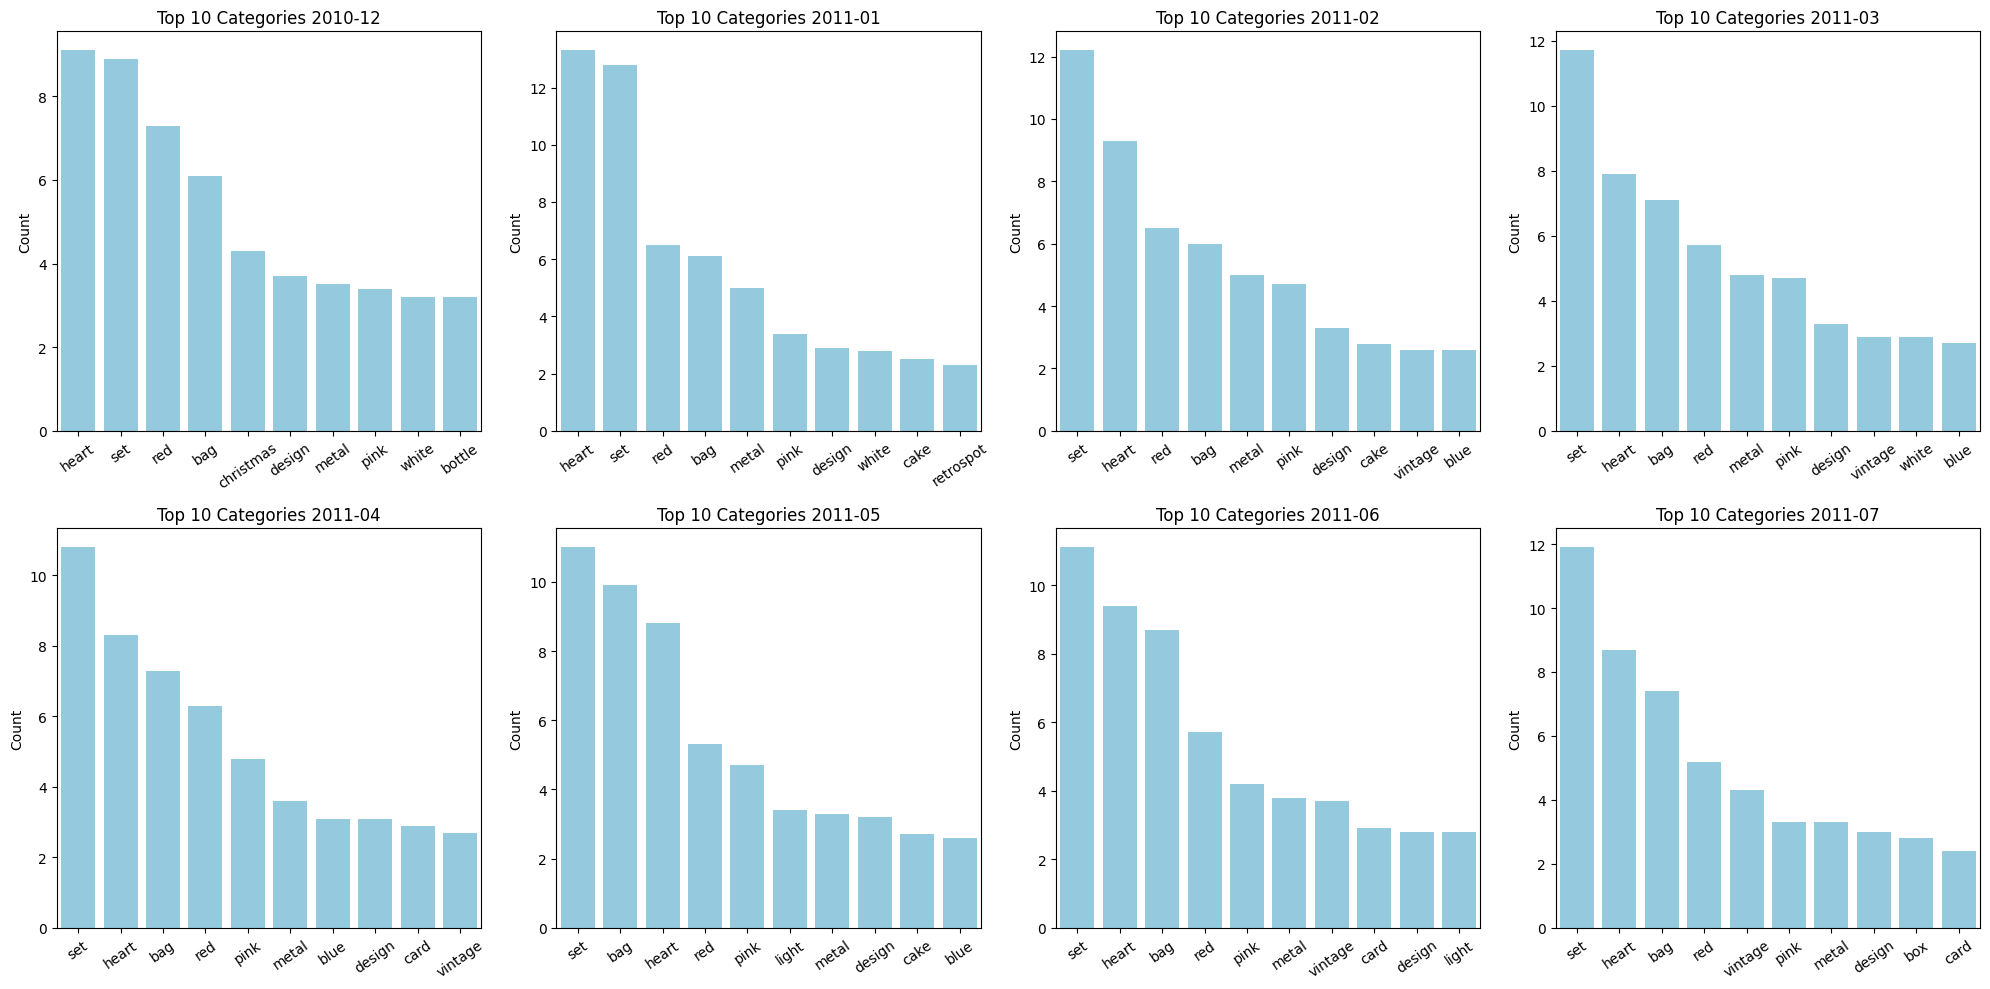

In [35]:
# 필터링 날짜 설정
target_2010 = pd.Period('2010-12', freq='M')
target_2011 = pd.Period('2011-07', freq='M')

# 2010년 12월 ~ 2011년 6월까지의 첫 구매 데이터 산출
cohort_2011 = ecommerce[(ecommerce['Month'] >= target_2010) & (ecommerce['Month'] <= target_2011) & (ecommerce['Month'] == ecommerce['BuyFirstMonth'])]
cohort_2011 = cohort_2011.groupby('Month')['category'].value_counts().reset_index(name = 'count')

# 월별 총수량, 비율 산출
cohort_2011['total'] = cohort_2011.groupby('Month')['count'].transform('sum')
cohort_2011_sorted = cohort_2011.sort_values(['Month', 'count'], ascending = [True, False])
cohort_2011['category_ratio'] = (cohort_2011['count'] / cohort_2011['total'] * 100).round(1)


months = cohort_2011['Month'].unique()

# 시각화
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
axes = axes.flatten()

for i, month in enumerate(months):
    ax = axes[i]
    data = cohort_2011[cohort_2011['Month'] == month].sort_values('count', ascending = False).head(10)

    sns.barplot(data=data, x='category', y='category_ratio', ax = ax, color = 'skyblue')

    ax.set_title(f"Top 10 Categories {month}")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation = 35)

plt.tight_layout()
plt.show()

> ##### 2011년 1월 이후 시즌이 끝나면서 시즌성 상품의 수요가 사라지고, 세트 상품이나 일반 상품이 주를 이룸

## 가설

### 1. 시즌 상품(Christmas)으로 유입된 고객은 비시즌 상품으로 유입된 고객보다 재구매 비율이 낮을 것이다.

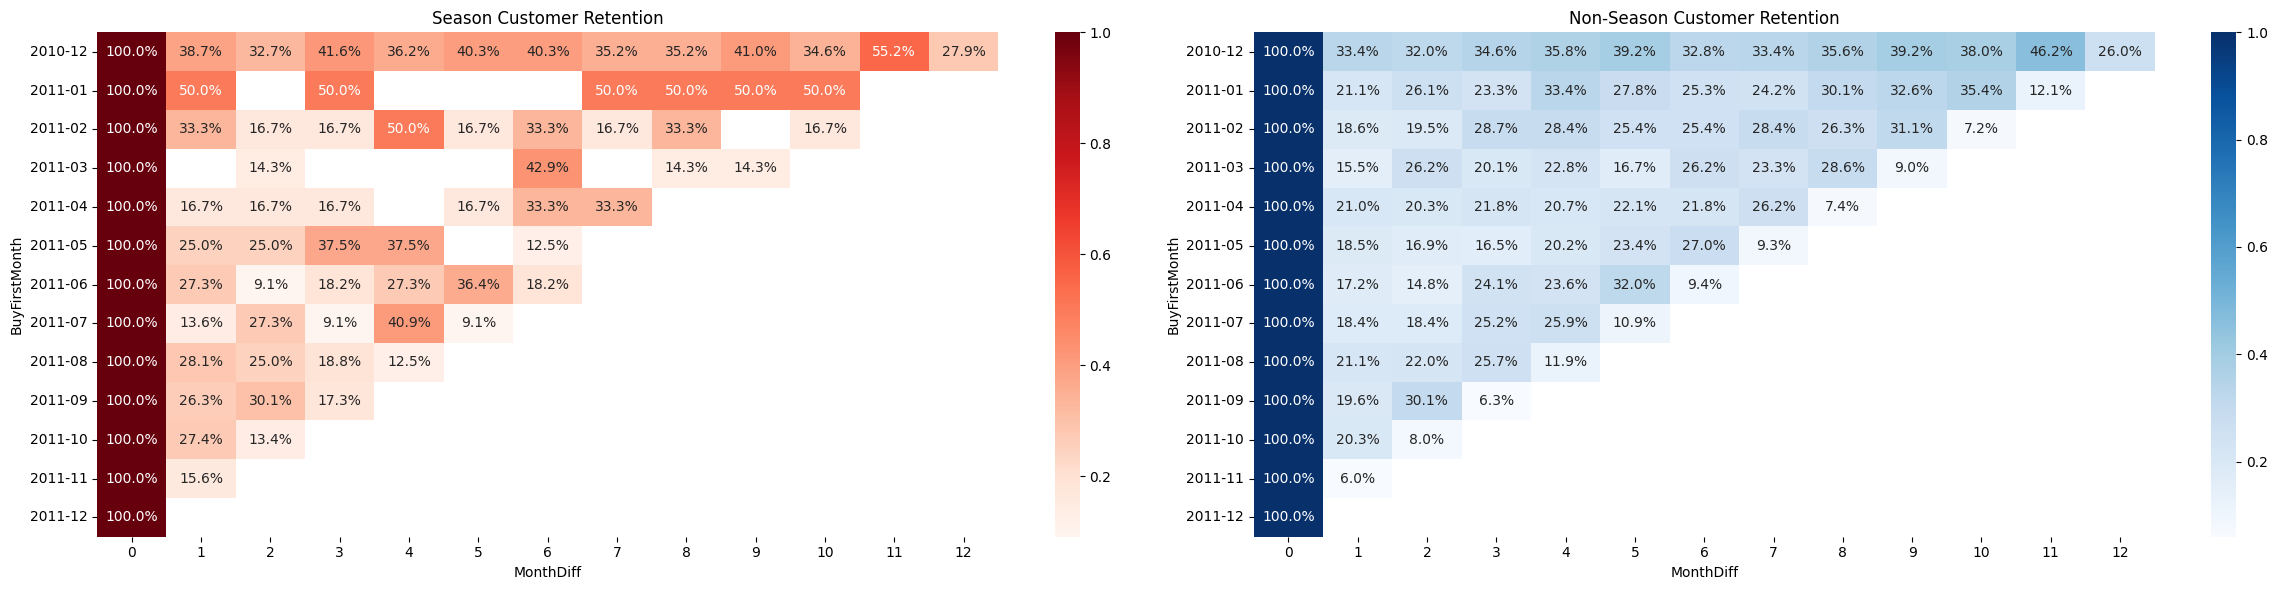

In [36]:
# 첫 구매 거래 데이터 필터링
first_purchase = ecommerce[ecommerce['MonthDiff'] == 0]

# 시즌 상품 구매 고객 필터링
customerID_chris = ecommerce[(ecommerce['category'] == 'christmas') & (ecommerce['MonthDiff'] == 0)]['CustomerID'].unique()

# 비시즌 상품 구매 고객 필터링
customerID_non = ecommerce[~ecommerce['CustomerID'].isin(customerID_chris)]['CustomerID'].unique()

christmas = ecommerce[ecommerce['CustomerID'].isin(customerID_chris)]
non_christmas = ecommerce[ecommerce['CustomerID'].isin(customerID_non)]

# 고객의 Retention 계산
cohort_christmas = get_Retention(christmas)
cohort_non_christmas = get_Retention(non_christmas)

# 시각화를 위한 Pivot Table 생성
retention_christmas_table = cohort_christmas.pivot(index='BuyFirstMonth', columns='MonthDiff', values='RetentionRate').round(3)
retention_non_christmas_table = cohort_non_christmas.pivot(index='BuyFirstMonth', columns='MonthDiff', values='RetentionRate').round(3)

fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.heatmap(retention_christmas_table, annot = True, fmt=".1%", cmap="Reds", ax = axes[0])
axes[0].set_title("Season Customer Retention")

sns.heatmap(retention_non_christmas_table, annot = True, fmt=".1%", cmap="Blues", ax = axes[1])
axes[1].set_title("Non-Season Customer Retention")

plt.tight_layout()
plt.show()

> ##### 단순 비율만 보면 시즌 상품 고객의 리텐션이 높게 나타남 그러나 실제 값은 대부분 0이거나 반복되어 나타나며, <br/> 이는 특정 고객의 다중 구매로 인한 영향으로 보여짐

> 비시즌 상품을 통해 유입된 고객은 안정적인 리텐션 패턴을 나타내며, 수치상 비율은 낮게 나타나더라도 상대적으로 다수 고객의 재방문이 이루어짐


##### -> 실제 재방문율은 시즌(Christmas) 상품으로 유입된 고객 보다 비시즌 상품으로 유입된 고객이 더 높음을 확인할 수 있다.


### 2. 세트(set) 상품을 구매한 고객(Cohort)은 재구매 비율이 높을 것이다.

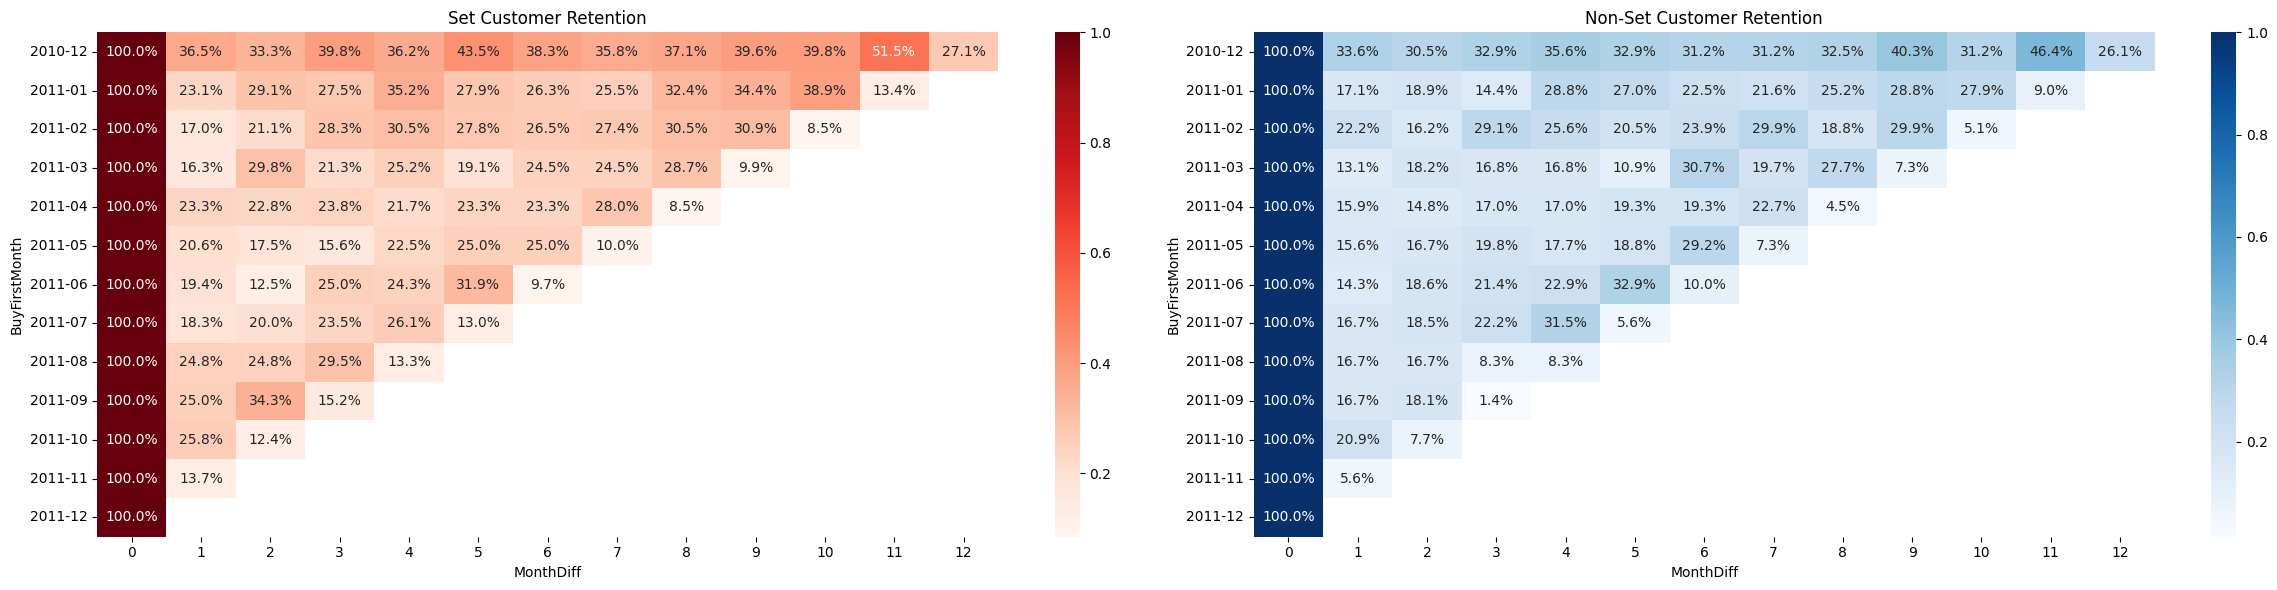

In [37]:
# 첫 구매 거래 데이터 필터링
first_purchase = ecommerce[ecommerce['MonthDiff'] == 0]

# 세트 상품 구매 고객 필터링
customerID_chris = ecommerce[(ecommerce['category'] == 'set') & (ecommerce['MonthDiff'] == 0)]['CustomerID'].unique()

# 세트 상품을 구매하지 않은 고객 필터링
customerID_non = ecommerce[~ecommerce['CustomerID'].isin(customerID_chris)]['CustomerID'].unique()

customer_set = ecommerce[ecommerce['CustomerID'].isin(customerID_chris)]
customer_non_set = ecommerce[ecommerce['CustomerID'].isin(customerID_non)]

# 각 고객(Cohort)의 Retention 계산
cohort_christmas = get_Retention(customer_set)
cohort_non_christmas = get_Retention(customer_non_set)

# 시각화를 위한 Pivot Table 생성
retention_christmas_table = cohort_christmas.pivot(index='BuyFirstMonth', columns='MonthDiff', values='RetentionRate').round(3)
retention_non_christmas_table = cohort_non_christmas.pivot(index='BuyFirstMonth', columns='MonthDiff', values='RetentionRate').round(3)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.heatmap(retention_christmas_table, annot = True, fmt=".1%", cmap="Reds", ax = axes[0])
axes[0].set_title("Set Customer Retention")

sns.heatmap(retention_non_christmas_table, annot = True, fmt=".1%", cmap="Blues", ax = axes[1])
axes[1].set_title("Non-Set Customer Retention")

plt.tight_layout()
plt.show()

In [38]:
cohort_mean_christmas = retention_christmas_table.mean(axis=1)
cohort_mean_non = retention_non_christmas_table.mean(axis=1)

total_mean_christmas = cohort_mean_christmas.mean().round(3)
total_mean_non = cohort_mean_non.mean().round(2)

print('Set를 구매한 고객의 Retention Avg : ', total_mean_christmas)
print('Set를 구매하지 않은 고객의 Retention Avg : ', total_mean_non)

Set를 구매한 고객의 Retention Avg :  0.423
Set를 구매하지 않은 고객의 Retention Avg :  0.38


#### 세트 상품을 구매 고객과 미구매 고객간의 리텐션 차이가 약 4%차이 나는 것을 확인

## 제안


### 1. 첫 구매에 시즌성 아이템을 구매한 고객들 대상으로 프로모션 이벤트 진행
↪ 첫 구매 이후 한달 뒤 할인 쿠폰 + 비시즌 상품 추천 방식을 이용하여 비시즌상품군으로 유도

<br/>

### 2. 아이템의 리뷰 컨텐츠를 활성화 하여 재방문 및 구매 전환을 유도
↪ 리뷰 작성 이벤트를 통해 고객 참여를 촉진하고, 베스트 리뷰 노출로 신뢰도를 높여 구매 전환 유도


In [40]:
ecommerce.to_csv('Preprocessing_ecommerec.csv', index = False, encoding = 'utf-8')